In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv('/Users/laurelxu/Desktop/ECS 171/Final Project/data.csv')
df.head()

,Rank,Game,Month,Year,Hours_watched,Hours_streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,Genre,Release_Year,Release_Month,New_Game,Wrong,rank_category
0,1,League of Legends,1,2016,94377226,1362044,530270,2903,129172,127021,1833,69.29,"Role-playing (RPG), Strategy, MOBA",2009,10,0.0,0.0,Top 10
1,2,Counter-Strike: Global Offensive,1,2016,47832863,830105,372654,2197,120849,64378,1117,57.62,"Shooter, Tactical",2012,08,0.0,0.0,Top 10
2,3,Dota 2,1,2016,45185893,433397,315083,1100,44074,60815,583,104.26,"Strategy, MOBA",2013,07,0.0,0.0,Top 10
3,4,Hearthstone,1,2016,39936159,235903,131357,517,36170,53749,317,169.29,"Strategy, Turn-based strategy (TBS), Card & Bo...",2014,03,0.0,0.0,Top 10
4,5,Call of Duty: Black Ops III,1,2016,16153057,1151578,71639,3620,214054,21740,1549,14.03,Shooter,2015,11,0.0,0.0,Top 10


In [3]:
label_encoder = LabelEncoder()
df['rank_category'] = label_encoder.fit_transform(df['rank_category'])

X = df[['Hours_watched', 'Hours_streamed', 'Peak_viewers', 'Peak_channels', 'Streamers', 'Avg_viewers', 'Avg_channels', 'Avg_viewer_ratio']]
y = df['rank_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

feature_names = X_train.columns 

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Selected Features: Index(['Hours_watched', 'Avg_viewers'], dtype='object')


/var/folders/r2/19qqvq2s2r98_0dqh9mb5vsm0000gn/T/ipykernel_15880/2631145801.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'RFE_Ranking', y = 'Feature', data = rfe_ranking_df, palette = 'viridis', orient = 'h')


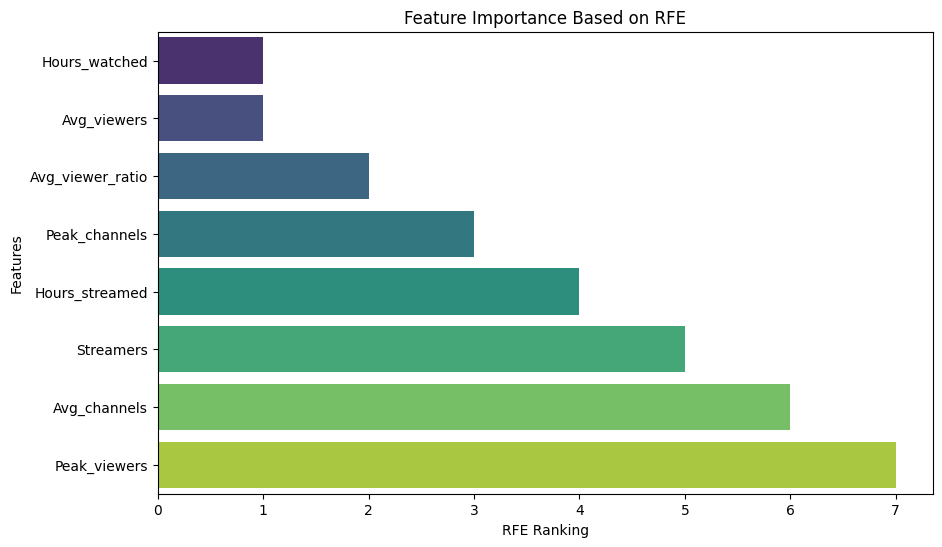

In [4]:
svm_model = SVC(kernel = 'linear')

rfe = RFE(svm_model, n_features_to_select = 2)
rfe.fit(X_train, y_train)

selected_features = feature_names[rfe.support_]
print('Selected Features:', selected_features)

rfe_ranking_df = pd.DataFrame({'Feature': feature_names, 'RFE_Ranking': rfe.ranking_})
rfe_ranking_df = rfe_ranking_df.sort_values(by = 'RFE_Ranking')

plt.figure(figsize=(10, 6))
sns.barplot(x = 'RFE_Ranking', y = 'Feature', data = rfe_ranking_df, palette = 'viridis', orient = 'h')

plt.xlabel('RFE Ranking')
plt.ylabel('Features')
plt.title('Feature Importance Based on RFE')
plt.show()

Model Accuracy: 0.77
              precision    recall  f1-score   support

      Top 10       0.89      0.75      0.81       221
     Top 100       0.66      0.45      0.54      1036
     Top 200       0.78      0.98      0.87      2088
      Top 50       0.83      0.66      0.73       855

    accuracy                           0.77      4200
   macro avg       0.79      0.71      0.74      4200
weighted avg       0.77      0.77      0.76      4200



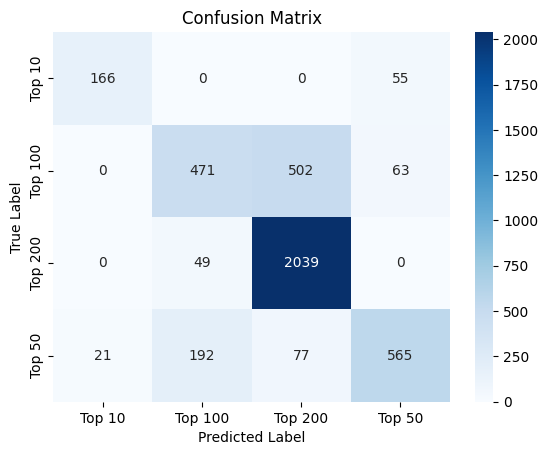

In [5]:
X = df[['Hours_watched', 'Avg_viewers']]
y = df['rank_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm_model = SVC(kernel = 'rbf', C = 1.0, gamma = 'scale')
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

y_pred_orig = label_encoder.inverse_transform(y_pred)
y_test_orig = label_encoder.inverse_transform(y_test)

accuracy = accuracy_score(y_test_orig, y_pred_orig)
print(f'Model Accuracy: {accuracy:.2f}')
print(classification_report(y_test_orig, y_pred_orig))

cm = confusion_matrix(y_test_orig, y_pred_orig)
categories = label_encoder.classes_
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = categories, yticklabels = categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [6]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid_search = GridSearchCV(SVC(), param_grid, cv = 5, scoring = 'accuracy', n_jobs = -1)
grid_search.fit(X_train, y_train)

print('Best Parameters:', grid_search.best_params_)
print('Best Accuracy:', grid_search.best_score_)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best Accuracy: 0.7704166666666665


Model Accuracy: 0.77
              precision    recall  f1-score   support

      Top 10       0.89      0.75      0.81       221
     Top 100       0.66      0.47      0.55      1036
     Top 200       0.78      0.98      0.87      2088
      Top 50       0.84      0.64      0.73       855

    accuracy                           0.77      4200
   macro avg       0.79      0.71      0.74      4200
weighted avg       0.77      0.77      0.76      4200



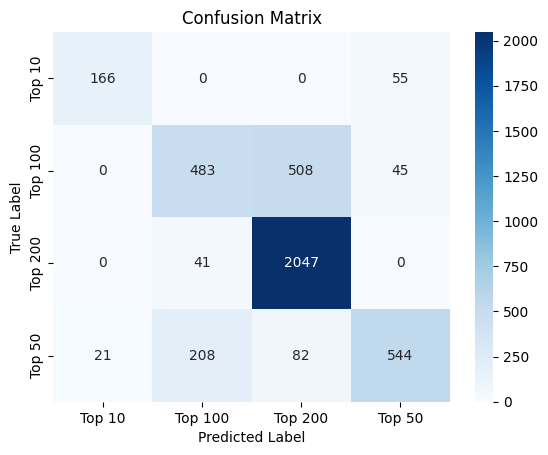

In [11]:
svm_model = SVC(kernel = 'rbf', C = 10, gamma = 'auto')
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

y_pred_orig = label_encoder.inverse_transform(y_pred)
y_test_orig = label_encoder.inverse_transform(y_test)

accuracy = accuracy_score(y_test_orig, y_pred_orig)
print(f'Model Accuracy: {accuracy:.2f}')
print(classification_report(y_test_orig, y_pred_orig))

cm = confusion_matrix(y_test_orig, y_pred_orig)
categories = label_encoder.classes_
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = categories, yticklabels = categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [12]:
y_test_bin = np.zeros((y_test.size, y_test.max() + 1))
y_test_bin[np.arange(y_test.size), y_test] = 1

y_pred_prob = svm_model.decision_function(X_test)
auc_score = roc_auc_score(y_test_bin, y_pred_prob, multi_class = 'ovr')

print('Multi-Class AUC Score:', auc_score)

Multi-Class AUC Score: 0.9052213201840004


In [9]:
predictions_df = pd.DataFrame({
    'Game': df.iloc[y_test.index]['Game'].values,
    'Actual Rank Category': y_test_orig,
    'Predicted Rank Category': y_pred_orig
})

print(predictions_df.head(30))

                                  Game Actual Rank Category  \
0                          Gang Beasts              Top 200   
1                Talk Shows & Podcasts               Top 50   
2                   Fallout: New Vegas              Top 200   
3         Animals, Aquariums, and Zoos              Top 100   
4                        The Long Dark              Top 200   
5                         StarCraft II              Top 100   
6                         Guild Wars 2              Top 100   
7                       Gears of War 4              Top 200   
8                  EA Sports FC Online              Top 200   
9                            Overwatch               Top 50   
10  The Legend of Zelda: Majora's Mask              Top 200   
11                                osu!              Top 100   
12                Old School RuneScape               Top 50   
13                           Overwatch               Top 50   
14                         Tower Unite              Top

In [10]:
valid_categories = ['Top 10', 'Top 50', 'Top 100', 'Top 200']

while True:
    user_input = input(f'Enter a rank category ({', '.join(valid_categories)}): ').strip()
    if user_input in valid_categories:
        break
    print('Invalid input. Please enter one of the specified categories.')

filtered_df = predictions_df[predictions_df['Predicted Rank Category'] == user_input]

if not filtered_df.empty:
    print(filtered_df.head(30))
else:
    print(f'No games found for the selected rank category: {user_input}')

Invalid input. Please enter one of the specified categories.
Invalid input. Please enter one of the specified categories.
                                 Game Actual Rank Category  \
22                             Dota 2               Top 10   
56                           Fortnite               Top 10   
74                       Apex Legends               Top 10   
101                     Just Chatting               Top 10   
102                 League of Legends               Top 10   
119                 Teamfight Tactics               Top 10   
127                          Among Us               Top 10   
139                 League of Legends               Top 10   
170                Grand Theft Auto V               Top 10   
177                     Just Chatting               Top 10   
202           PokÃ©mon Scarlet/Violet               Top 50   
203                            Dota 2               Top 10   
213                          Fortnite               Top 10   
249       